In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')
import os
import importlib
module_name = "Functions"
if module_name in sys.modules:
    del sys.modules[module_name]
Functions = importlib.import_module(module_name)

from Functions_HuggingFace import *

import esm
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd 
import numpy as np
import torch



import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO

from Bio import Entrez
from Bio import SeqIO

from transformers import EsmForMaskedLM, T5EncoderModel,T5Tokenizer,DataCollatorForLanguageModeling
from transformers.modeling_outputs import MaskedLMOutput


# Run code

In [2]:
model_layers = 36

model_raw, alphabet = esm.pretrained.load_model_and_alphabet('esm2_t36_3B_UR50D')
model_raw.eval()
batch_converter = alphabet.get_batch_converter()

sub_mod='ESM2-H3'
sub_mod='ESM2-HA80'
modnam="/home3/oml4h/hugging_face_downloads/model_weights_topublish/{}".format(sub_mod)
out='/home3/oml4h/PLM_SARS-CoV-2/Results/test/'

model = EsmForMaskedLM.from_pretrained(modnam)



if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Transferred model to GPU")

else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")
model =  model.to(device)


Transferred model to GPU


In [3]:
query_path = "/home3/oml4h/PLM_SARS-CoV-2/Sequences/huH3N2_HA_CDS.translated_extra_steps.fas"

reference_path = "/home3/oml4h/PLM_SARS-CoV-2/Sequences/H3N2_canonical.fa"

sequences = read_sequences_to_dict(query_path)

sequences



# 1. Read the reference sequence (Assuming single sequence in file)
# We use 'next' to get the first item from the iterator
ref_record = next(SeqIO.parse(reference_path, "fasta"))
ref_seq_str = str(ref_record.seq)



# 2. Read the query sequences
# We parse the file and pick the first one as a test case
query_iterator = SeqIO.parse(query_path, "fasta")
first_query_record = next(query_iterator)

h3_map_with_ha2 = create_h3_numbering_map(first_query_record, ref_seq_str, HA2_start=330)




In [4]:
ids=list(sequences.keys())




In [5]:
J_indexed_muts = [m for m in get_reference_mutations(ref = sequences[ids[0]],mut = sequences[ids[len(ids)-1]]) if "-" not in m  ] 
K_indexed_muts = [m for m in get_mutations(sequences[ids[0]],sequences[ids[len(ids)-1]]) if "del" not in m and '-' not in m  ] 
# Convert your mutations to canonical numbering
canonical_mutations = mutations_to_canonical(K_indexed_muts, h3_map_with_ha2)
print("K->J mutations")
print(K_indexed_muts)

K->J mutations
['K18N', 'N138D', 'T151K', 'S160N', 'N174D', 'I176K', 'Q189R', 'K205R', 'K292E', 'T344A', 'S394N']


In [6]:
mutation_dictionary  = {k:J_indexed_muts[i] for i,k in enumerate(K_indexed_muts)}

In [7]:
# get info on model layers:
model_layers_info = model.config.to_dict()
print(model_layers_info)
#print how many layers the model has
print("Number of layers in the model: ", model_layers_info['num_hidden_layers'] + 1)  # +1 for the embedding layer

{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': 'float32', 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'chunk_size_feed_forward': 0, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_supp

In [8]:
#pd.DataFrame(columns=["Mutation","rel_grammar","rel_seq_grammar","semanatic_score","probability","Backbone"])
mut_info_rows=[]

#loop through each node in the tree except the last one (lineage of interest)
for backbone_i in range(len(ids)-1):
    backbone = ids[backbone_i]
    print("Calculating mutations on backbone:",backbone)
    reference_spike_sequence = sequences[backbone]
    #calculate mutation differences between node and K lineage
    J_indexed_muts = [m for m in get_reference_mutations(ref = sequences[backbone],mut = sequences[ids[len(ids)-1]]) if "-" not in m  ] 
    K_indexed_muts = [m for m in get_mutations(sequences[backbone],sequences[ids[len(ids)-1]]) if "del" not in m and '-' not in m  ] 
    # Convert your mutations to canonical numbering
    canonical_mutations = mutations_to_canonical(K_indexed_muts, h3_map_with_ha2)
    mutation_dictionary  = {k:J_indexed_muts[i] for i,k in enumerate(K_indexed_muts)}
    canon_dict={k:canonical_mutations[i] for i,k in enumerate(K_indexed_muts)}
    print("K->J mutations")
    print(K_indexed_muts)
    #loop through each mutation and calculate the scores on the focal node
    for mut in mutation_dictionary.keys():
        if backbone ==  ids[len(ids)-1]:
            sequence = revert_sequence(reference_spike_sequence,[mut])
        else:
            sequence = mutate_sequence(reference_spike_sequence,[mut])
        reference = reference_spike_sequence
        mutations = embed_protein_sequences(
            [[mut,sequence.replace("-","")]],
            reference.replace("-",""),
            'S:0',
            model,
            model_layers,
            device,
            batch_converter,
            alphabet,
            scores=True)
   
        
        #append mutation info to dataframe
        new_row={"Mutation":mut,
                 'canon':canon_dict[mut],
                 'sequence_grammar':mutations[mut]["S:0"]["sequence_grammaticality"],
                    "rel_grammar":mutations[mut]["S:0"]["relative_grammaticality"],
                    "rel_seq_grammar":mutations[mut]["S:0"]["relative_sequence_grammaticality"],
                    "narrow_seq_grammar":mutations[mut]["S:0"]["narrow_sequence_grammaticality"],
                    "relative_narrow_seq_grammar":mutations[mut]["S:0"]["relative_narrow_sequence_grammaticality"],
                    "semanatic_score":mutations[mut]["S:0"]["semantic_score"],
                    "probability":mutations[mut]["S:0"]["probability"],
                    "Backbone":backbone}
        mut_info_rows.append(new_row)

# Add final row: full sequence grammar for the final lineage
final_lineage_name = ids[-1].split("|")[-1]
first_lineage_name = ids[0].split("|")[-1]
print(f"\nCalculating full sequence grammar for {final_lineage_name} (relative to {first_lineage_name})")

final_sequence = sequences[ids[-1]]
first_sequence = sequences[ids[0]]

# Use process_protein_sequence directly instead of embed_protein_sequences
final_result = process_protein_sequence(
    final_sequence.replace("-", ""),
    model,
    model_layers,
    batch_converter,
    alphabet,
    device
)

# Get reference result for comparison
reference_result = process_protein_sequence(
    first_sequence.replace("-", ""),
    model,
    model_layers,
    batch_converter,
    alphabet,
    device
)

# Calculate relative scores
rel_grammar = final_result["sequence_grammaticality"] - reference_result["sequence_grammaticality"]
rel_seq_grammar = final_result["sequence_grammaticality"] - reference_result["sequence_grammaticality"]
semantic_score = semantic_calc(final_result["Mean_Embedding"], reference_result["Mean_Embedding"])

# Add row for full sequence (narrow grammar won't be meaningful here)
new_row = {
    "Mutation": f"{first_lineage_name}_to_{final_lineage_name}",
    'canon': f"{first_lineage_name}_to_{final_lineage_name}",
    'sequence_grammar':final_result["sequence_grammaticality"],
    "rel_grammar": rel_grammar,
    "rel_seq_grammar": rel_seq_grammar,
    "narrow_seq_grammar": np.nan,  # Not meaningful for full sequence
    "relative_narrow_seq_grammar": np.nan,  # Not meaningful for full sequence
    "semanatic_score": semantic_score,
    "probability": np.nan,
    "Backbone": ids[0]  # Reference is the first sequence
}
# and add one for the OG
# Add row for full sequence (narrow grammar won't be meaningful here)
new_row = {
    "Mutation": f"{first_lineage_name}_",
    'canon': f"{first_lineage_name}",
    'sequence_grammar':reference_result["sequence_grammaticality"],
    "rel_grammar":  np.nan,
    "rel_seq_grammar":  np.nan,
    "narrow_seq_grammar": np.nan,  # Not meaningful for full sequence
    "relative_narrow_seq_grammar": np.nan,  # Not meaningful for full sequence
    "semanatic_score": semantic_score,
    "probability":  np.nan,
    "Backbone": ids[0]  # Reference is the first sequence
}
mut_info_rows.append(new_row)

mut_info=pd.DataFrame(mut_info_rows)

Calculating mutations on backbone: EPI2178977|HA|A/Thailand/8/2022|EPI_ISL_14991375|J
K->J mutations
['K18N', 'N138D', 'T151K', 'S160N', 'N174D', 'I176K', 'Q189R', 'K205R', 'K292E', 'T344A', 'S394N']


[['K18N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAMSCFLLCIALLGFIMWACQKGNIRCNICIX']]
[['K18N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKNESFNWTGVKQNGTSSACKRGSSSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDKNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGKCKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTNEK

# model each backbone separately just for gramaticality of whole sequence

In [9]:
# Calculate full sequence grammar for all backbones
backbone_grammar_rows = []

# Get the first sequence as reference
first_sequence = sequences[ids[0]]
first_lineage_name = ids[0].split("|")[-1]

# Process reference sequence once
reference_result = process_protein_sequence(
    first_sequence.replace("-", ""),
    model,
    model_layers,
    batch_converter,
    alphabet,
    device
)

print(f"Processing all backbone sequences relative to {first_lineage_name}...\n")

# Loop through all sequences
for backbone_i, backbone_id in enumerate(ids):
    lineage_name = backbone_id.split("|")[-1]
    print(f"Processing {lineage_name} ({backbone_i+1}/{len(ids)})")
    
    # Get current sequence
    current_sequence = sequences[backbone_id]
    
    # Process current sequence
    current_result = process_protein_sequence(
        current_sequence.replace("-", ""),
        model,
        model_layers,
        batch_converter,
        alphabet,
        device
    )
    
    # Calculate semantic change from first sequence
    if backbone_i == 0:
        semantic_change = 0.0  # First sequence has zero change
    else:
        semantic_change = semantic_calc(
            current_result["Mean_Embedding"], 
            reference_result["Mean_Embedding"]
        )
    
    # Add row to results
    new_row = {
        "Lineage": lineage_name,
        "Full_ID": backbone_id,
        "sequence_grammar": current_result["sequence_grammaticality"],
        "semantic_change_from_first": semantic_change,
        "order": backbone_i
    }
    backbone_grammar_rows.append(new_row)

# Create dataframe and save
backbone_grammar_df = pd.DataFrame(backbone_grammar_rows)
output_file = out + f"{sub_mod}_backbone_sequence_grammar.csv"
backbone_grammar_df.to_csv(output_file, index=False)

print(f"\nSaved backbone sequence grammar to: {output_file}")
print("\nSummary:")
print(backbone_grammar_df)

Processing all backbone sequences relative to J...

Processing J (1/9)
Processing J (2/9)
Processing J.2 (3/9)
Processing J.2 (4/9)
Processing J.2.4 (5/9)
Processing J.2.4_I160K (6/9)
Processing J.2.4_I160K_N158D_T328A (7/9)
Processing J.2.4_I160K_N158D_T328A_S144N (8/9)
Processing J.2.4.1 (9/9)

Saved backbone sequence grammar to: /home3/oml4h/PLM_SARS-CoV-2/Results/test/ESM2-HA80_backbone_sequence_grammar.csv

Summary:
                         Lineage  \
0                              J   
1                              J   
2                            J.2   
3                            J.2   
4                          J.2.4   
5                    J.2.4_I160K   
6        J.2.4_I160K_N158D_T328A   
7  J.2.4_I160K_N158D_T328A_S144N   
8                        J.2.4.1   

                                             Full_ID  sequence_grammar  \
0  EPI2178977|HA|A/Thailand/8/2022|EPI_ISL_149913...        -67.332214   
1  EPI2096148|HA|A/Massachusetts/18/2022|EPI_ISL_...        -67.33

In [10]:
#
mut_info["lineage_backbone"]=mut_info["Backbone"].str.split("|").str[-1]
mut_info
mut_info.to_csv(out+"H3_epistasis_mutation_info_spyros_model_{}.csv".format(sub_mod)
,index=False)
print(mut_info.loc[mut_info['Mutation']=='I176K'])


   Mutation  canon  sequence_grammar  rel_grammar  rel_seq_grammar  \
5     I176K  I160K        -68.059532     1.862888        -0.727318   
16    I176K  I160K        -68.059532     1.862888        -0.727318   
27    I176K  I160K        -72.153000     2.105804        -0.173820   
37    I176K  I160K        -72.153000     2.105804        -0.173820   
45    I176K  I160K        -72.614090     2.296327         0.122482   

    narrow_seq_grammar  relative_narrow_seq_grammar  semanatic_score  \
5           -68.000420                    -3.421188         4.449192   
16          -68.000420                    -3.421188         4.449192   
27          -72.118584                    -2.906601         4.344539   
37          -72.118584                    -2.906601         4.344539   
45          -72.571007                    -2.810661         4.284155   

    probability                                           Backbone  \
5      0.410616  EPI2178977|HA|A/Thailand/8/2022|EPI_ISL_149913...   
16    

# do each mutation by itself and then do each pairwise comparison 

In [11]:
backbone_id=ids[4]
K_indexed_muts = [m for m in get_mutations(sequences[backbone_id],sequences[ids[len(ids)-1]]) if "del" not in m and '-' not in m  ] 
print("K->J mutations")
print(K_indexed_muts)



K->J mutations
['K18N', 'S160N', 'N174D', 'I176K', 'Q189R', 'T344A', 'S394N']


In [12]:
# backbone = "Wuhan-Hu-1"

backbone=backbone_id
reference_spike_sequence = sequences[backbone]

#create dict of point mutation backbones for all of the mutations in  K_indexed_muts, with names as keys
point_mutations={}
for mut in K_indexed_muts:
    point_mutations[mut]=mutate_sequence(reference_spike_sequence,[mut])

mut_info_rows=[]
plm_entropy=[]
plm_probability=[]

#loop through each point mutation
for backbone_i in range(len(K_indexed_muts)+1):
    
    if backbone_i == len(K_indexed_muts):
        backbone = reference_spike_sequence
        backbone_name="Reference"
    else:
        backbone = point_mutations[list(point_mutations.keys())[backbone_i]]
        backbone_name=list(point_mutations.keys())[backbone_i]
    
    for mutation_j in range(len(K_indexed_muts)):
        if backbone_i == mutation_j:
            print(f"Skipping mutation {K_indexed_muts[mutation_j]} on its own backbone")
            continue
        mut=K_indexed_muts[mutation_j]
        mutate_sequence(reference_spike_sequence,[mut])
        
   

        sequence = mutate_sequence(backbone,[mut])

        reference = backbone
        mutations = embed_protein_sequences(
            [[mut,sequence.replace("-","")]],
            backbone.replace("-",""),
            'S:0',
            model,
            model_layers,
            device,
            batch_converter,
            alphabet,
            scores=True)
        


        
        #append mutation info to dataframe
        new_row={"Mutation":mut,"rel_grammar":mutations[mut]["S:0"]["relative_grammaticality"],
                                    "rel_seq_grammar":mutations[mut]["S:0"]["relative_sequence_grammaticality"],
                                    "narrow_seq_grammar":mutations[mut]["S:0"]["narrow_sequence_grammaticality"],
                                    "relative_narrow_seq_grammar":mutations[mut]["S:0"]["relative_narrow_sequence_grammaticality"],
                                    "semanatic_score":mutations[mut]["S:0"]["semantic_score"],
                                    "probability":mutations[mut]["S:0"]["probability"],
                                    "Backbone": backbone_name,
                                    }
        mut_info_rows.append(new_row)

        plm_entropy.append({"Mutation":mut,"Backbone":backbone_name,"entropy":mutations[mut]["S:0"]["entropy"]})
        plm_probability.append({"Mutation":mut,"Backbone":backbone_name,"probability":mutations[mut]["S:0"]["sequence_probabilities"]})   
        
plm_entropy.append({"Mutation":"reference","Backbone":"reference","entropy":mutations["Reference"]["S:0"]["sequence_entropy"]})
plm_probability.append({"Mutation":"reference","Backbone":"reference","probability":mutations["Reference"]["S:0"]["sequence_probabilities"]})

mut_info_combos=pd.DataFrame(mut_info_rows)



Skipping mutation K18N on its own backbone


[['S160N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGKSSACKRGSNSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDRNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTNEKFHQIEKEFSEVEGRVQDLEKYVEDTKIDLWSYNAELLVALENQHTIDLTDSEMNKLFEKTKKQLRENAEDMGNGCFKIYHKCDNACIGSIRNETYDHNVYRDEALNNRFQIKGVELKSGYKDWILWISFAMSCFLLCIALLGFIMWACQKGNIRCNICIX']]
[['S160N', 'MKAIIALSNILCLVFAQNIPGNDNSTATLCLGHHAVPNGTIVKTITNDRIEVTNATELVQNSSIGKICNSPHQILDGGNCTLIDALLGDPQCDGFQNKEWDLFVERSRANSSCYPYDVPDYASLRSLVASSGTLEFKDESFNWTGVKQNGKSSACKRGSNSSFFSRLNWLTSLNNIYPAQNVTMPNKEQFDKLYIWGVHHPDTDRNQFSLFAQSSGRITVSTKRSQQAVIPNIGSRPRVRDIPSRISIYWTIVKPGDILLINSTGNLIAPRGYFKIRSGKSSIMRSDAPIGECKSECITPNGSIPNDKPFQNVNRITYGACPRYVKQSTLKLATGMRNVPEKQTRGIFGAIAGFIENGWEGMVDGWYGFRHQNSEGRGQAADLKSTQAAIDQISGKLNRLIGKTN

In [13]:


mut_info_combos.to_csv(out+sub_mod+'_mut_info_combos.csv',index=False)   
def make_wide_dataframe(data_list, value_name="site"):
    """
    Converts list of dicts with a list-column into a wide dataframe.
    """
    # Create initial DF
    df = pd.DataFrame(data_list)
    
    # Expand the 'data' column into separate columns
    # resulting shape: (N_samples, Sequence_Length)
    expanded = pd.DataFrame(df[value_name].to_list())
    
    # Rename columns to 1-based site indices (e.g., site_1, site_2...)
    expanded.columns = [f"{value_name}_{i+1}" for i in range(expanded.shape[1])]
    
    # Concatenate ID columns with the expanded data
    # Axis 1 joins columns
    final_df = pd.concat([df[['Mutation', 'Backbone']], expanded], axis=1)
    
    return final_df

# Generate the Wide DataFrames
mut_info_combos = pd.DataFrame(mut_info_rows)
entropy_wide = make_wide_dataframe(plm_entropy, value_name="entropy")
probability_wide = make_wide_dataframe(plm_probability, value_name="probability")

entropy_wide.to_csv(out+sub_mod+'_entropy.csv',index=False)
probability_wide.to_csv(out+sub_mod+'_probability.csv',index=False)



In [14]:
backbone=backbone_id
reference_spike_sequence = sequences[backbone]
result = get_mutation_prob_matrix(reference_spike_sequence, model, model_layers, device, batch_converter, alphabet)
mutation_prob_matrix = result['mutation_matrix']
amino_acids = result['amino_acids']
positions = result['positions']

# Get max non-reference probability for each site
# Loop through each position (column) and mask out the reference amino acid
max_non_reference_probs = []
for site_idx, pos in enumerate(positions):
    ref_aa = reference_spike_sequence[site_idx]  # Get the reference amino acid at this position
    
    # Get all probabilities at this site
    site_probs = mutation_prob_matrix[:, site_idx].copy()
    
    # Only mask out the reference if it's one of the 20 standard amino acids
    # If it's X or another non-standard AA, just take the max of all 20
    if ref_aa in amino_acids:
        ref_aa_idx = amino_acids.index(ref_aa)  # Get its index in the amino_acids list
        # Mask out the reference amino acid
        site_probs[ref_aa_idx] = -np.inf  # Set reference to very low value so it won't be max
    # modify mutation_prob_matrix to make reference sites probabilities zero
    mutation_prob_matrix[ref_aa_idx, site_idx] = np.nan
    # Get the maximum of the remaining (mutant) probabilities
    max_mutant_prob = site_probs.max()
    max_non_reference_probs.append(max_mutant_prob)

max_non_reference_probs = np.array(max_non_reference_probs)

{'K18N', 'Q189R', 'T344A', 'N174D', 'S394N', 'I176K', 'S160N'}
[18, 189, 344, 174, 394, 176, 160]
{'probability_567': 1, 'probability_9': 2, 'probability_180': 3, 'probability_500': 4, 'probability_208': 5, 'probability_211': 6, 'probability_172': 7, 'probability_176': 8, 'probability_147': 9, 'probability_394': 10, 'probability_110': 11, 'probability_422': 12, 'probability_294': 13, 'probability_3': 14, 'probability_202': 15, 'probability_175': 16, 'probability_99': 17, 'probability_138': 18, 'probability_292': 19, 'probability_538': 20, 'probability_112': 21, 'probability_205': 22, 'probability_137': 23, 'probability_545': 24, 'probability_151': 25, 'probability_154': 26, 'probability_206': 27, 'probability_189': 28, 'probability_160': 29, 'probability_239': 30, 'probability_49': 31, 'probability_187': 32, 'probability_108': 33, 'probability_78': 34, 'probability_19': 35, 'probability_66': 36, 'probability_156': 37, 'probability_277': 38, 'probability_161': 39, 'probability_505': 40,

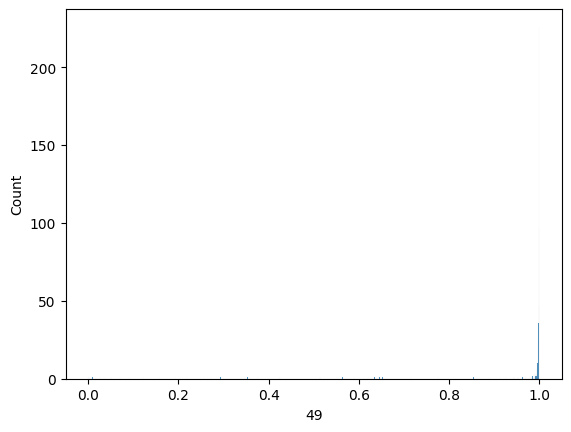

In [ ]:
mutated_sites=set(mut_info_combos["Mutation"])
print(mutated_sites)
#strip out letters
import seaborn
#sns.histplot(entropy_wide.iloc[-1,2:])
sns.histplot(probability_wide.iloc[-1,2:])

numeric_positions = [int(re.search(r'\d+', site).group()) for site in mutated_sites]
print(numeric_positions) # Sort the list for easier reading/comparison


target_series = probability_wide.iloc[-1, 2:]

# Convert the target series to a dictionary for fast lookup: {position: probability}
# Assuming column names (indices) are the residue positions (as in the mock setup)
position_to_prob = target_series.to_dict()

# Calculate Ranks: Assign a rank (1 being highest probability)
# Get the values and sort them in descending order
sorted_probs = target_series.sort_values(ascending=True)
# Create a rank series (using .rank() is safer for ties, but a simple lookup is faster here)
# Rank is 1 + index in the sorted list (since index starts at 0)
position_to_rank = {pos: rank + 1 for rank, pos in enumerate(sorted_probs.index)}
print(position_to_rank)
print(probability_wide.columns)

# Rank the max non-reference probabilities (highest value = rank 1)
# Create position-indexed ranking for max_non_reference_probs
max_nonref_with_positions = [(i+1, val) for i, val in enumerate(max_non_reference_probs)]
# Sort by value descending (highest first)
sorted_max_nonref = sorted(max_nonref_with_positions, key=lambda x: x[1], reverse=True)
# Create rank lookup: position -> rank (1 = highest)
position_to_nonref_rank = {pos: rank + 1 for rank, (pos, val) in enumerate(sorted_max_nonref)}

results = []
for mut_num, pos in enumerate(numeric_positions):
    prob = probability_wide["probability_"+str(pos)].tail(1).item()
    entropy=entropy_wide["entropy_"+str(pos)].tail(1).item()
    rank = position_to_rank["probability_"+str(pos)]
    # rank non-reference peak:
    rank_nonref = position_to_nonref_rank[pos]
    max_nonref_prob = max_non_reference_probs[pos-1]  # Get the actual max non-ref probability

    results.append({
        "mutation": list(mutated_sites)[mut_num],
        "Position": pos,
        "Probability_reference": prob,
        "entropy":entropy,
        "prob_mutation":mut_info_combos["probability"][(mut_info_combos["Mutation"]==list(mutated_sites)[mut_num] ) & 
                                        (mut_info_combos["Backbone"]=="Reference" )].item(),
        "reference_probability_rank": rank,
        "Max_non_reference_probability": max_nonref_prob,
        "Rank_max_non_reference": rank_nonref
    })

# Convert the results list to a DataFrame for clean, tabular output
results_df = pd.DataFrame(results).sort_values(by="Position").reset_index(drop=True)
# flatten mutation_prob_matrix
mutation_prob_flat = mutation_prob_matrix.flatten()
mutation_prob_flat_clean = mutation_prob_flat[~np.isnan(mutation_prob_flat)]

# Calculate percentile of observed mutation probabilities against all possible non-reference mutation probabilities
results_df["probability_percentile"] = np.sum(mutation_prob_flat_clean < results_df["prob_mutation"].values[:, None], axis=1) / len(mutation_prob_flat_clean) * 100

results_df.to_csv(os.path.join(out, sub_mod+'_epistasis_results.csv'),index=False)


In [ ]:
results_df
# note that rank max-non-reference can point to a different mutation

,mutation,Position,Probability_reference,entropy,prob_mutation,reference_probability_rank,Max_non_reference_probability,Rank_max_non_reference,probability_percentile
0,K18N,18,0.995014,0.039066,0.000722,83,0.001864,113,95.683654
1,S160N,160,0.620410,0.993925,0.230575,29,0.230575,33,99.675114
2,N174D,174,0.991296,0.063376,0.001727,63,0.004643,70,97.484452
3,I176K,176,0.050985,1.143707,0.506666,8,0.506667,20,99.814351
4,Q189R,189,0.590323,1.032634,0.026326,28,0.316804,31,99.359510
5,T344A,344,0.998372,0.015062,0.000491,167,0.000512,230,94.411956
6,S394N,394,0.091039,0.345330,0.903717,10,0.903717,8,99.925740


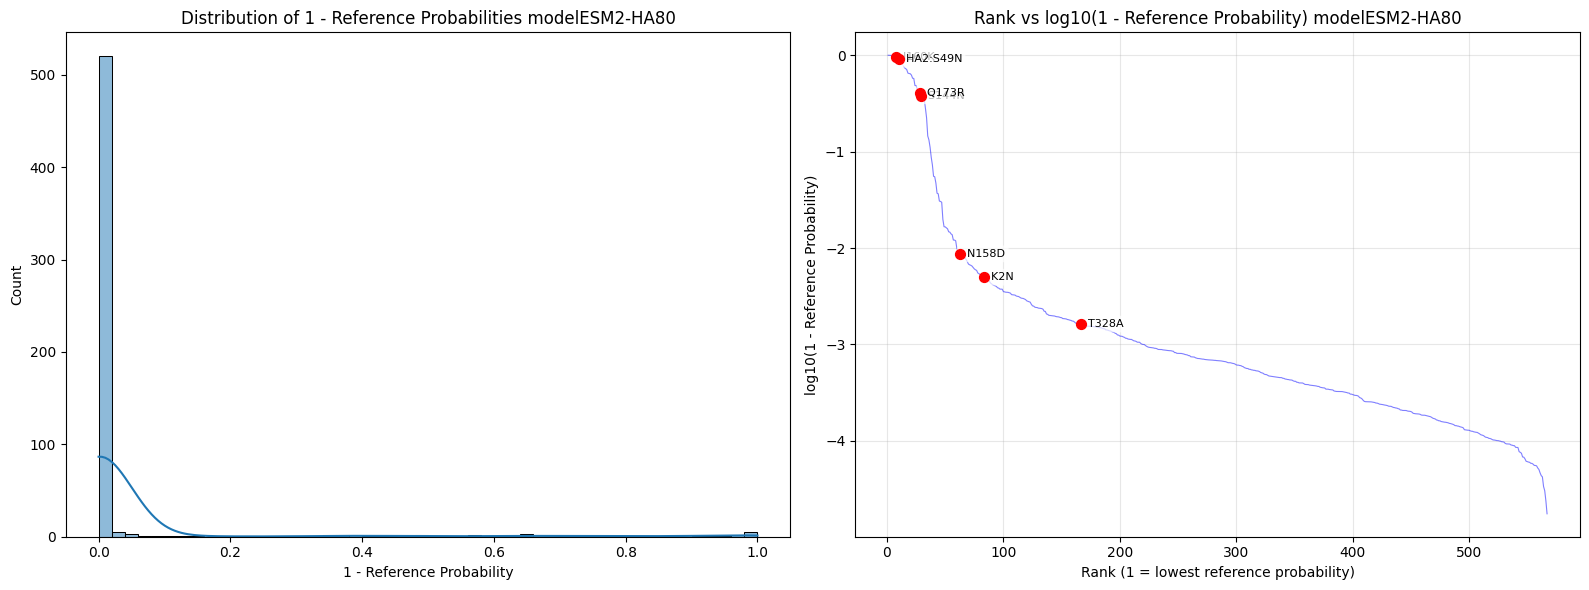

Summary Statistics for 1 - Reference Probability:
Mean: 0.0437
Median: 0.0007
Min: 0.0000
Max: 1.0000
Std: 0.1718


In [16]:
# make a histogram of reference probabilities
target_series = probability_wide.iloc[-1, 2:]
one_minus_ref_probs = 1 - target_series.values

# Create canonical mutation mapping for focal mutations
canonical_mutations = mutations_to_canonical(K_indexed_muts, h3_map_with_ha2)
canon_dict = {k: canonical_mutations[i] for i, k in enumerate(K_indexed_muts)}

# Create figure with two subplots
plt.figure(figsize=(16, 6))

# Subplot 1: Histogram
plt.subplot(1, 2, 1)
sns.histplot(one_minus_ref_probs, bins=50, kde=True)
plt.xlabel('1 - Reference Probability')
plt.ylabel('Count')
plt.title('Distribution of 1 - Reference Probabilities model{}'.format(sub_mod))

# Subplot 2: Rank vs log10(1 - Reference Probability)
plt.subplot(1, 2, 2)
# Sort by reference probability (ascending) to get ranks
sorted_indices = np.argsort(target_series.values)
sorted_ref_probs = target_series.values[sorted_indices]
sorted_one_minus = 1 - sorted_ref_probs
ranks = np.arange(1, len(sorted_one_minus) + 1)

# Convert to numpy array to avoid pandas Series issue
sorted_one_minus_array = np.array(sorted_one_minus, dtype=float)
plt.plot(ranks, np.log10(sorted_one_minus_array), linewidth=0.8, color='blue', alpha=0.5)

# Add scatter points and text labels for focal mutations
for mut in K_indexed_muts:
    # Extract position from mutation
    pos = int(re.search(r'\d+', mut).group())
    
    # Get the probability column name
    prob_col = f"probability_{pos}"
    
    # Find this position's reference probability
    if prob_col in target_series.index:
        ref_prob = target_series[prob_col]
        one_minus_prob = 1 - ref_prob
        
        # Find the rank of this position
        rank = position_to_rank[prob_col]
        
        # Get canonical name
        canon_name = canon_dict[mut]
        
        # Plot scatter point
        plt.scatter(rank, np.log10(one_minus_prob), color='red', s=50, zorder=5)
        
        # Add text label
        plt.text(rank, np.log10(one_minus_prob), f'  {canon_name}', 
                fontsize=8, ha='left', va='center', 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlabel('Rank (1 = lowest reference probability)')
plt.ylabel('log10(1 - Reference Probability)')
plt.title('Rank vs log10(1 - Reference Probability) model{}'.format(sub_mod))
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(out, f"{sub_mod}_reference_probability_analysis.png"), dpi=300)
plt.show()

# Print summary statistics
print("Summary Statistics for 1 - Reference Probability:")
print(f"Mean: {one_minus_ref_probs.mean():.4f}")
print(f"Median: {np.median(one_minus_ref_probs):.4f}")
print(f"Min: {one_minus_ref_probs.min():.4f}")
print(f"Max: {one_minus_ref_probs.max():.4f}")
print(f"Std: {one_minus_ref_probs.std():.4f}")

([<matplotlib.axis.XTick at 0x7f9a9086dc10>,
 [Text(0, 0, '1'),
  Text(10, 0, '11'),
  Text(20, 0, '21'),
  Text(30, 0, '31'),
  Text(40, 0, '41'),
  Text(50, 0, '51'),
  Text(60, 0, '61'),
  Text(70, 0, '71'),
  Text(80, 0, '81'),
  Text(90, 0, '91'),
  Text(100, 0, '101'),
  Text(110, 0, '111'),
  Text(120, 0, '121'),
  Text(130, 0, '131'),
  Text(140, 0, '141'),
  Text(150, 0, '151'),
  Text(160, 0, '161'),
  Text(170, 0, '171'),
  Text(180, 0, '181'),
  Text(190, 0, '191'),
  Text(200, 0, '201'),
  Text(210, 0, '211'),
  Text(220, 0, '221'),
  Text(230, 0, '231'),
  Text(240, 0, '241'),
  Text(250, 0, '251'),
  Text(260, 0, '261'),
  Text(270, 0, '271'),
  Text(280, 0, '281'),
  Text(290, 0, '291'),
  Text(300, 0, '301'),
  Text(310, 0, '311'),
  Text(320, 0, '321'),
  Text(330, 0, '331'),
  Text(340, 0, '341'),
  Text(350, 0, '351'),
  Text(360, 0, '361'),
  Text(370, 0, '371'),
  Text(380, 0, '381'),
  Text(390, 0, '391'),
  Text(400, 0, '401'),
  Text(410, 0, '411'),
  Text(420,

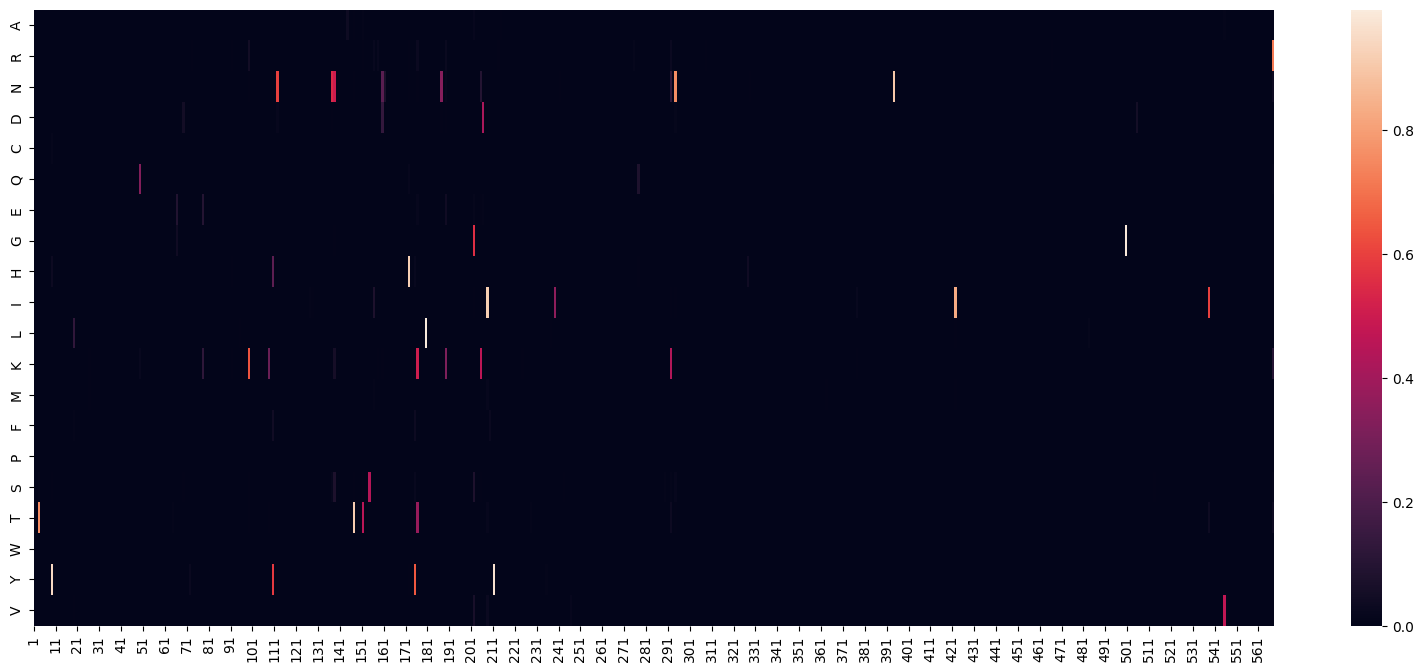

In [17]:


# seaborn heatmap of mutation_prob_flat
plt.figure(figsize=(20, 8))
#only label every tenth x axis tick
mutation_prob_matrix2 = np.nan_to_num(mutation_prob_matrix, nan=0.0)
# replace np.nan with zero for visualization

seaborn.heatmap(mutation_prob_matrix2, xticklabels=positions, yticklabels=amino_acids)
plt.xticks(ticks=np.arange(0, len(positions), 10), labels=np.array(positions)[::10])

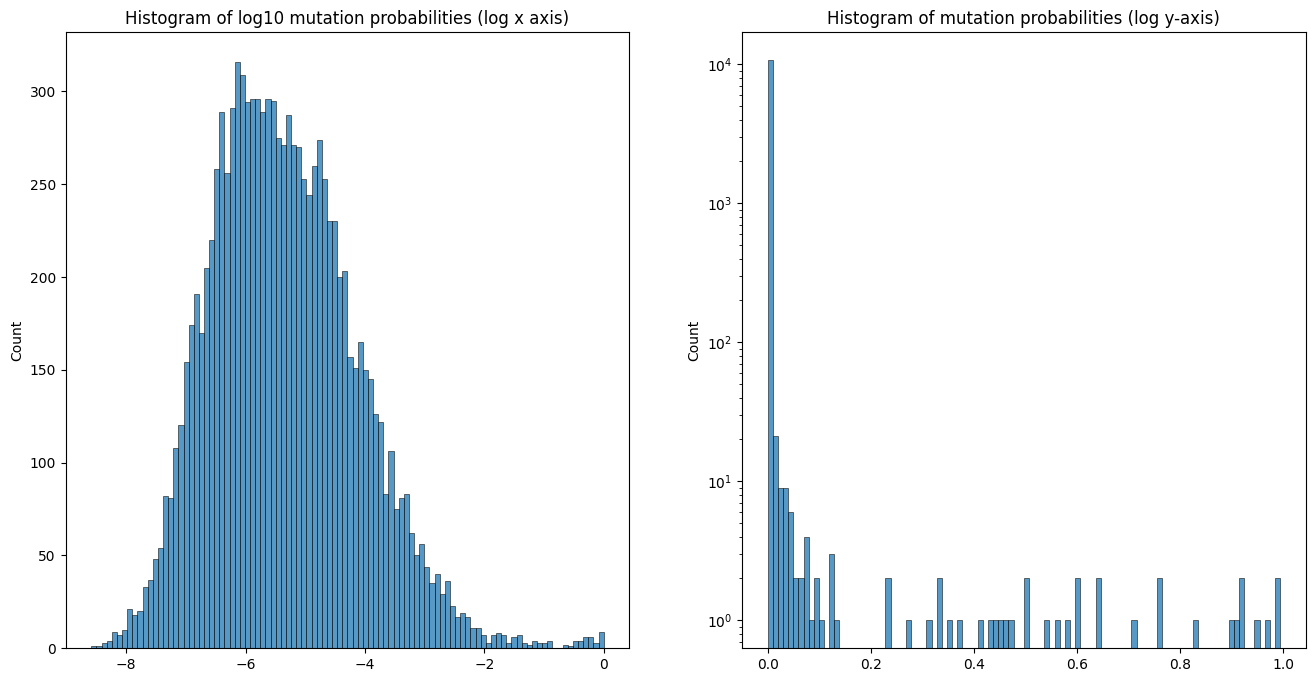

In [18]:
# seaborn histogram of mutation_prob_flat panel side by side

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
# log x axis before plotting
mutation_prob_matrix_log=np.log10(mutation_prob_matrix + 1e-10)  # add small constant to avoid log(0)
plt.title("Histogram of log10 mutation probabilities (log x axis)")
sns.histplot(mutation_prob_matrix_log.flatten(), bins=100)
#plot again with log y axis
#log yaxis log x axis
plt.subplot(1, 2, 2)
plt.title("Histogram of mutation probabilities (log y-axis)")
sns.histplot(mutation_prob_matrix.flatten(), bins=100)
plt.yscale('log')


In [19]:
# Find top 10 non-reference mutations with highest probabilities in mutation_prob_matrix
# Flatten the matrix and get indices of top values
mutation_prob_matrix2 = np.nan_to_num(mutation_prob_matrix, nan=-np.inf)  # Replace NaN with -inf to ignore reference sites
top_10_indices = np.argsort(mutation_prob_matrix2.flatten())[-10:][::-1]  # Get top 10, descending

# Convert flat indices back to 2D coordinates
top_10_coords = np.unravel_index(top_10_indices, mutation_prob_matrix.shape)

# Flatten entropy for all positions to calculate percentiles
entropy_all = entropy_wide.iloc[-1, 2:].values  # All entropy values from reference

# Create a dataframe with the results
top_mutations = []
for i in range(10):
    aa_idx = top_10_coords[0][i]
    pos_idx = top_10_coords[1][i]
    position = positions[pos_idx]
    amino_acid = amino_acids[aa_idx]
    probability = mutation_prob_matrix[aa_idx, pos_idx]
    ref_aa = reference_spike_sequence[pos_idx]
    
    # Format as mutation string
    mutation_str = f"{ref_aa}{position}{amino_acid}"
    
    # Check if this mutation is in the mutations of interest (K_indexed_muts)
    # Look for exact match or matching position
    mutation_of_interest = None
    for mut in K_indexed_muts:
        # Extract position from mutation string (e.g., "S394N" -> 394)
        mut_pos = int(re.search(r'\d+', mut).group())
        if mut_pos == position:
            mutation_of_interest = mut
            break
    
    # Get entropy for this position from entropy_wide (last row = reference)
    entropy_at_position = entropy_wide[f"entropy_{position}"].tail(1).item()
    
    # Calculate entropy percentile (what percentage of sites have lower entropy)
    entropy_percentile = (np.sum(entropy_all < entropy_at_position) / len(entropy_all)) * 100
    
    top_mutations.append({
        'Rank': i + 1,
        'Mutation': mutation_str,
        'Position': position,
        'Reference_AA': ref_aa,
        'Mutant_AA': amino_acid,
        'Probability': probability,
        'Entropy': entropy_at_position,
        'Entropy_Percentile': entropy_percentile,
        'Mutation_of_Interest': mutation_of_interest if mutation_of_interest else 'NA',
        'AA_Index': aa_idx,
        'Position_Index': pos_idx
    })

top_mutations_df = pd.DataFrame(top_mutations)
print("Top 10 non-reference mutations with highest probabilities:")
top_mutations_df

Top 10 non-reference mutations with highest probabilities:


,Rank,Mutation,Position,Reference_AA,Mutant_AA,Probability,Entropy,Entropy_Percentile,Mutation_of_Interest,AA_Index,Position_Index
0,1,Q180L,180,Q,L,0.993839,0.046196,87.477954,NA,10,179
1,2,E500G,500,E,G,0.989736,0.064408,89.417989,NA,7,499
2,3,F211Y,211,F,Y,0.970165,0.148940,92.063492,NA,18,210
3,4,N9Y,9,N,Y,0.944418,0.283640,93.650794,NA,18,8
4,5,S172H,172,S,H,0.922661,0.406071,94.532628,NA,8,171
5,6,F208I,208,F,I,0.916494,0.421554,94.708995,NA,9,207
6,7,K147T,147,K,T,0.913192,0.365396,94.356261,NA,16,146
7,8,S394N,394,S,N,0.903717,0.345330,94.179894,S394N,2,393
8,9,V422I,422,V,I,0.830401,0.514880,95.414462,NA,9,421
9,10,A3T,3,A,T,0.760907,0.649981,95.590829,NA,16,2


In [20]:
mut_info_combos.head()

,Mutation,rel_grammar,rel_seq_grammar,narrow_seq_grammar,relative_narrow_seq_grammar,semanatic_score,probability,Backbone
0,S160N,-0.946969,-3.248863,-75.576599,-3.710403,6.596790,0.238815,K18N
1,N174D,-6.359474,3.556679,-68.354645,3.987740,9.146610,0.001715,K18N
2,I176K,2.146142,-0.119713,-72.426292,-2.896835,4.435177,0.508805,K18N
3,Q189R,-3.210114,-1.844139,-73.885643,-1.997269,12.311827,0.025399,K18N
4,T344A,-7.628034,-1.332642,-72.153183,0.196495,2.133473,0.000486,K18N
